In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string

In [2]:
# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /Users/asma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/asma/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/asma/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
df = pd.read_csv('spam_ham_dataset.csv')

In [4]:
# Explore the data
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nColumn info:")
print(df.info())
print("\nLabel distribution:")
print(df['label'].value_counts())

Dataset shape: (5171, 4)

First few rows:
   Unnamed: 0 label                                               text  \
0         605   ham  Subject: enron methanol ; meter # : 988291\r\n...   
1        2349   ham  Subject: hpl nom for january 9 , 2001\r\n( see...   
2        3624   ham  Subject: neon retreat\r\nho ho ho , we ' re ar...   
3        4685  spam  Subject: photoshop , windows , office . cheap ...   
4        2030   ham  Subject: re : indian springs\r\nthis deal is t...   

   label_num  
0          0  
1          0  
2          0  
3          1  
4          0  

Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB
None

Label

In [5]:
def basic_cleaning(df):
    # Check for missing values
    print("Missing values:")
    print(df.isnull().sum())
    
    # Remove duplicates
    initial_count = len(df)
    df = df.drop_duplicates()
    print(f"Removed {initial_count - len(df)} duplicates")
    
    # Check column names and standardize if needed
    print("Column names:", df.columns.tolist())
    
    return df

df = basic_cleaning(df)

Missing values:
Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64
Removed 0 duplicates
Column names: ['Unnamed: 0', 'label', 'text', 'label_num']


In [6]:
class EmailPreprocessor:
    def __init__(self):
        self.stemmer = PorterStemmer()
        self.stop_words = set(stopwords.words('english'))
        
    def clean_text(self, text):
        """Basic text cleaning"""
        if pd.isna(text):
            return ""
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        
        # Remove email addresses
        text = re.sub(r'\S*@\S*\s?', '', text)
        
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def tokenize_and_stem(self, text):
        """Tokenize and apply stemming"""
        tokens = word_tokenize(text)
        
        # Remove stopwords and apply stemming
        filtered_tokens = [
            self.stemmer.stem(word) for word in tokens 
            if word not in self.stop_words and len(word) > 2
        ]
        
        return filtered_tokens
    
    def preprocess_email(self, email_text):
        """Complete preprocessing pipeline for a single email"""
        cleaned_text = self.clean_text(email_text)
        tokens = self.tokenize_and_stem(cleaned_text)
        return ' '.join(tokens)

In [7]:
# Initialize preprocessor
preprocessor = EmailPreprocessor()

# Apply preprocessing to the email text column
# Assuming the text column is named 'text' - adjust based on your dataset
print("Starting text preprocessing...")

# Create processed text column
df['processed_text'] = df['text'].apply(preprocessor.preprocess_email)

# Check results
print("\nOriginal text sample:")
print(df['text'].iloc[0][:200] + "...")
print("\nProcessed text sample:")
print(df['processed_text'].iloc[0][:200] + "...")

Starting text preprocessing...

Original text sample:
Subject: enron methanol ; meter # : 988291
this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary
flow data provided by daren } .
please override pop ' s daily volume { pre...

Processed text sample:
subject enron methanol meter follow note gave monday preliminari flow data provid daren pleas overrid pop daili volum present zero reflect daili activ obtain ga control chang need asap econom purpos...


In [8]:
def extract_features(df):
    """Extract additional features from emails"""
    
    # Text length features
    df['original_length'] = df['text'].str.len()
    df['processed_length'] = df['processed_text'].str.len()
    
    # Word count features
    df['original_word_count'] = df['text'].str.split().str.len()
    df['processed_word_count'] = df['processed_text'].str.split().str.len()
    
    # Check for common spam indicators
    df['has_urgent_keywords'] = df['text'].str.contains(
        r'\b(urgent|important|alert|warning|immediately)\b', 
        case=False, regex=True
    ).astype(int)
    
    df['has_dollar_signs'] = df['text'].str.contains(r'\$').astype(int)
    df['has_exclamation_marks'] = df['text'].str.contains(r'!{2,}').astype(int)
    
    # Capitalization ratio (spam often has more caps)
    df['caps_ratio'] = df['text'].apply(
        lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0
    )
    
    return df

df = extract_features(df)

print("Feature statistics:")
print(df[['original_length', 'processed_length', 'original_word_count', 
          'processed_word_count', 'has_urgent_keywords']].describe())

/var/folders/3s/04zht0_50n998df765p7wwmr0000gn/T/ipykernel_26014/1311249028.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['has_urgent_keywords'] = df['text'].str.contains(


Feature statistics:
       original_length  processed_length  original_word_count  \
count      5171.000000       5171.000000          5171.000000   
mean       1048.391994        572.763102           227.783601   
std        1528.513435        915.318451           336.031616   
min          11.000000          7.000000             1.000000   
25%         244.000000        126.000000            51.000000   
50%         540.000000        281.000000           121.000000   
75%        1237.000000        644.500000           282.000000   
max       32258.000000      19530.000000          8862.000000   

       processed_word_count  has_urgent_keywords  
count           5171.000000          5171.000000  
mean              91.585187             0.046799  
std              141.833704             0.211229  
min                1.000000             0.000000  
25%               21.000000             0.000000  
50%               45.000000             0.000000  
75%              103.000000          

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

print("Label mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")

# Split the data
X = df['processed_text']
y = df['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=5,
    max_df=0.7,
    ngram_range=(1, 2),  # Include unigrams and bigrams
    stop_words='english'
)

print("Fitting TF-IDF vectorizer...")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF matrix shape - Train: {X_train_tfidf.shape}, Test: {X_test_tfidf.shape}")

Label mapping:
ham: 0
spam: 1

Training set size: 4136
Test set size: 1035
Fitting TF-IDF vectorizer...
TF-IDF matrix shape - Train: (4136, 5000), Test: (1035, 5000)


In [10]:
# Save processed dataset
df.to_csv('processed_spam_dataset.csv', index=False)

# Save TF-IDF features and labels for modeling
import joblib

joblib.dump(X_train_tfidf, 'X_train_tfidf.pkl')
joblib.dump(X_test_tfidf, 'X_test_tfidf.pkl')
joblib.dump(y_train, 'y_train.pkl')
joblib.dump(y_test, 'y_test.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

print("Preprocessing completed! Files saved:")
print("- processed_spam_dataset.csv")
print("- TF-IDF features and labels")

Preprocessing completed! Files saved:
- processed_spam_dataset.csv
- TF-IDF features and labels


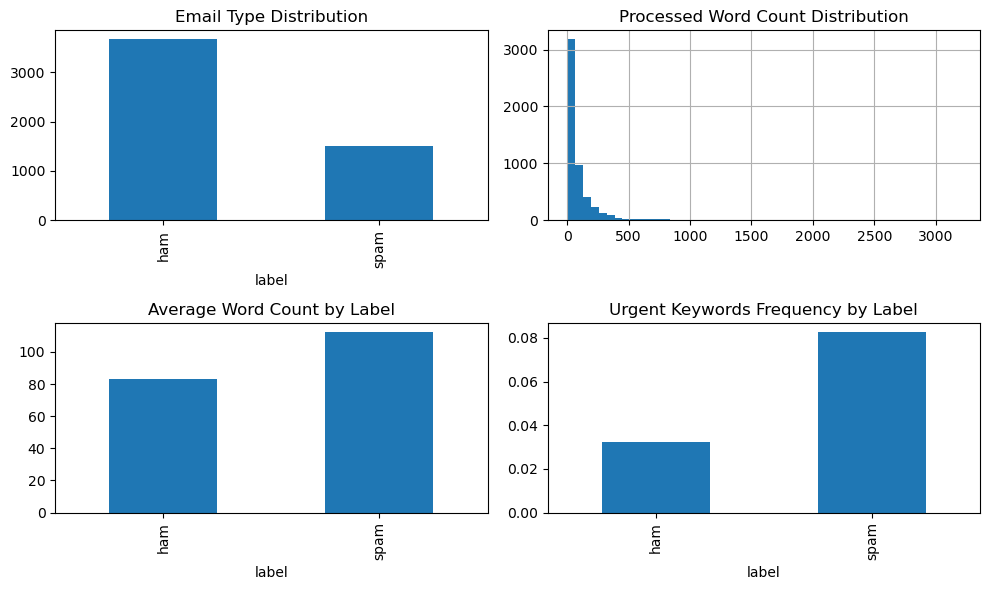

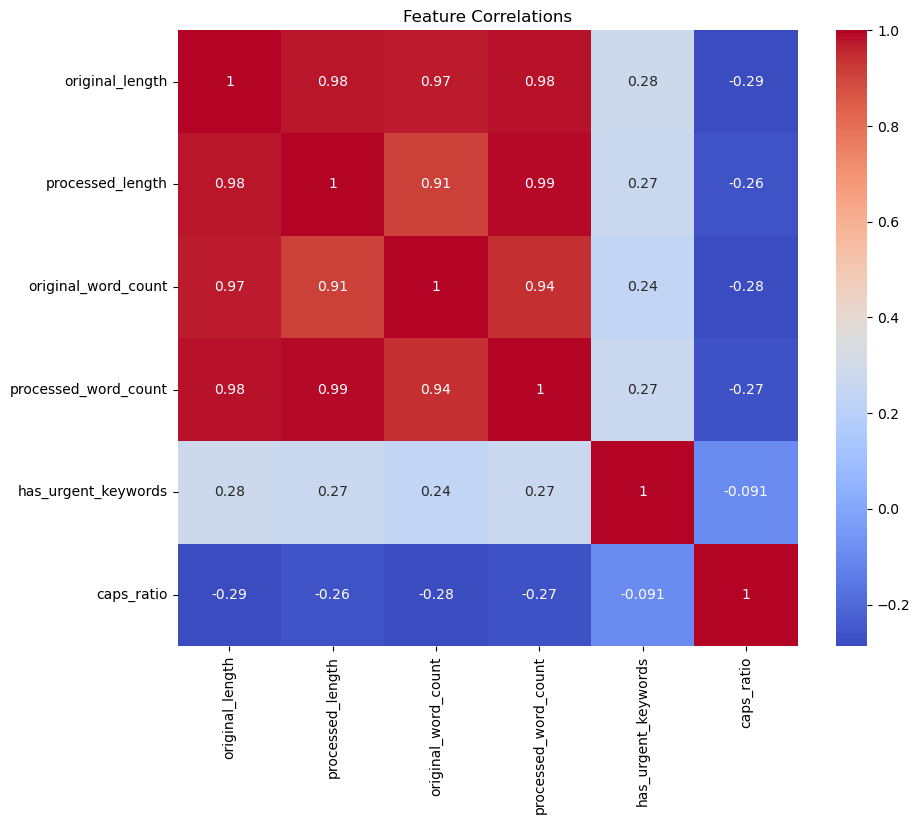

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize label distribution
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
df['label'].value_counts().plot(kind='bar')
plt.title('Email Type Distribution')

plt.subplot(2, 2, 2)
df['processed_word_count'].hist(bins=50)
plt.title('Processed Word Count Distribution')

plt.subplot(2, 2, 3)
df.groupby('label')['processed_word_count'].mean().plot(kind='bar')
plt.title('Average Word Count by Label')

plt.subplot(2, 2, 4)
df.groupby('label')['has_urgent_keywords'].mean().plot(kind='bar')
plt.title('Urgent Keywords Frequency by Label')

plt.tight_layout()
plt.show()

# Correlation heatmap for numerical features
numerical_features = ['original_length', 'processed_length', 
                     'original_word_count', 'processed_word_count',
                     'has_urgent_keywords', 'caps_ratio']

plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlations')
plt.show()